In [29]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [30]:
df =pd.read_sql_table('printer', 'sqlite:///dissertation.db')

In [31]:
df_copy = df.copy()

In [32]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,55.0,-1,0,0,0,weekday,0.000153
1,2019-12-23 00:00:10,55.0,-1,0,0,0,weekday,0.000153
2,2019-12-23 00:00:20,55.0,-1,0,0,0,weekday,0.000153
3,2019-12-23 00:00:30,55.0,-1,0,0,0,weekday,0.000153
4,2019-12-23 00:00:40,55.0,-1,0,0,0,weekday,0.000153
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,55.5,23,6,23,59,holiday,0.000154
1451516,2020-06-07 23:59:20,55.5,23,6,23,59,holiday,0.000154
1451517,2020-06-07 23:59:30,56.0,23,6,23,59,holiday,0.000156
1451518,2020-06-07 23:59:40,55.5,23,6,23,59,holiday,0.000154


In [33]:
# group by half an hour
df_half = pd.DataFrame ({'Actual':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [34]:
df_sub = df_half[:6451]

In [8]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_sub.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -9.996266
p-value: 0.000000
Critial Values:
   1%, -4.372937294115271
Critial Values:
   5%, -3.83331091190546
Critial Values:
   10%, -3.5538306043089496


In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

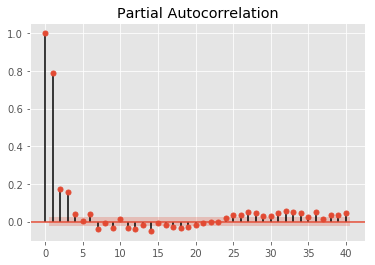

In [10]:
plot_pacf(df_sub.Actual, lags=40)
plt.show()

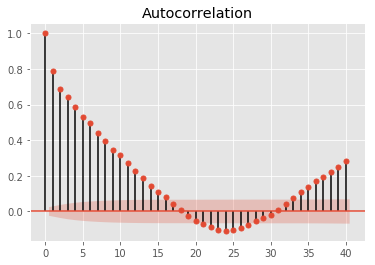

In [11]:
plot_acf(df_sub.Actual, lags=40)
plt.show()

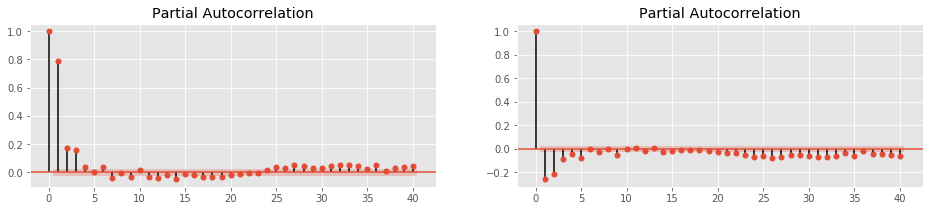

In [12]:
# one differencing pacf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(df_sub.Actual, lags=40, ax=axes[0])
plot_pacf(df_sub.Actual.diff().dropna(),lags=40, ax=axes[ 1])

plt.show()

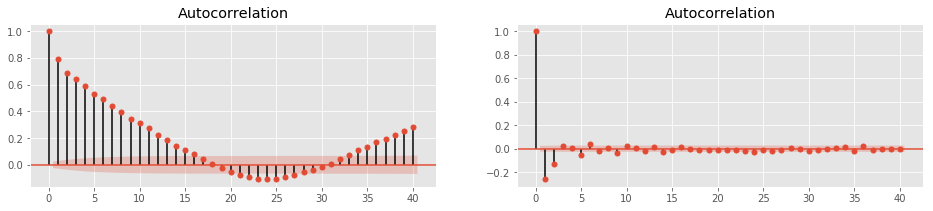

In [13]:
# one differencing acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_acf(df_sub.Actual, lags=40, ax=axes[0])
plot_acf(df_sub.Actual.diff().dropna(),lags=40, ax=axes[ 1])

plt.show()

In [35]:
# arima (2,1,1)
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_sub.Actual, order=(1,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 6451
Model:                     ARMA(1, 2)   Log Likelihood              -23394.537
Method:                       css-mle   S.D. of innovations              9.093
Date:                Thu, 20 Aug 2020   AIC                          46799.074
Time:                        18:58:52   BIC                          46832.934
Sample:                    12-23-2019   HQIC                         46810.790
                         - 05-05-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           34.3260      0.836     41.058      0.000      32.687      35.965
ar.L1.Actual     0.9194      0.006    142.874      0.000       0.907       0.932
ma.L1.Actual    -0.2974      0.014    -21.02

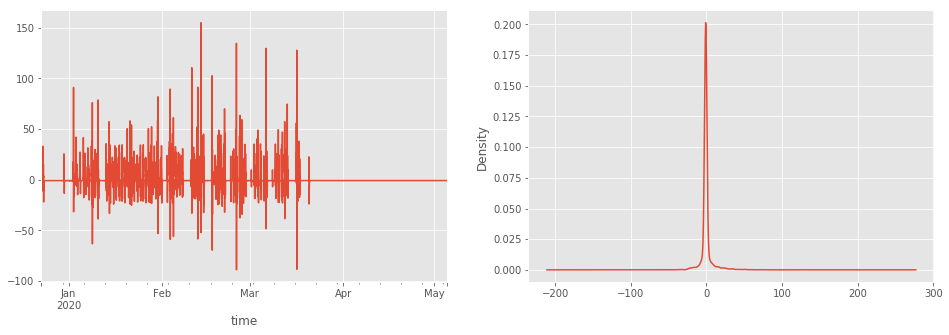

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit.resid.plot(ax=axes[0])
model_fit.resid.plot(kind='kde', ax=axes[1])

In [88]:
# using one difference
#diff1 = df_sub['Actual'].diff().diff()
#df_diff1 = pd.DataFrame(diff1)

Text(0, 0.5, 'Wh')

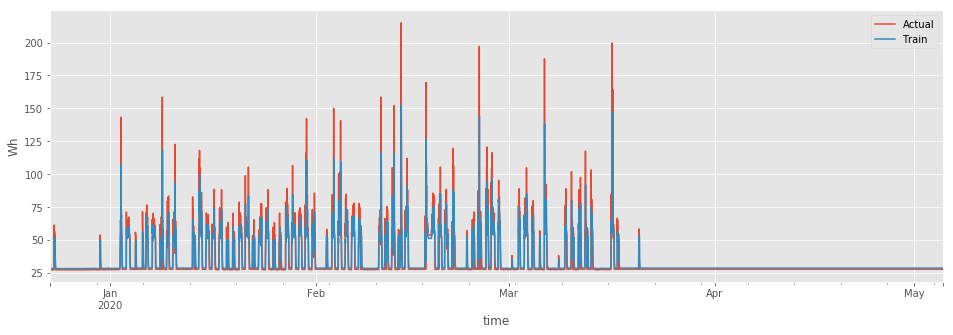

In [37]:
# predict the model
predict= model_fit.predict(dynamic=False)
df_predict= pd.DataFrame(predict, columns=({'Train'}))
df_sub_pred = df_sub.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_sub_pred.set_index(df_sub_pred.index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [38]:
next_halfhour=model_fit.forecast(steps=1, exog=None, alpha=0.05)
print(next_halfhour)
print('Actual: ',df_half['Actual'][5044:5045])

(array([28.85521188]), array([9.09271683]), array([[11.03381437, 46.6766094 ]]))
Actual:  time
2020-04-06 02:00:00    28.0
Freq: 30T, Name: Actual, dtype: float64


In [39]:
mae = np.mean(np.abs(df_sub_pred['Train'] - df_sub_pred['Actual']))
rmse = np.mean((df_sub_pred['Train'] - df_sub_pred['Actual'])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  3.3606047709445326 RMSE:  9.092971658490812


In [40]:
# with lockdown
mad_mean_ratio =3.36*6451/(df_sub_pred['Actual']).sum() 
mad_mean_ratio

0.09782398008185621

## Decomposed Seasonal Model

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose seasonal 
decom = seasonal_decompose(df_sub['Actual'], model='addicative', extrapolate_trend='freq', freq=336)
detrended = df_sub.Actual.values - decom.seasonal
detrended = pd.DataFrame(detrended,columns={'Actual'})

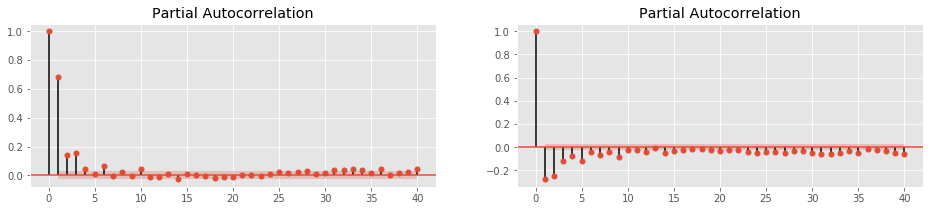

In [93]:
# one differencing pacf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(detrended.Actual, lags=40, ax=axes[0])
plot_pacf(detrended.Actual.diff().dropna(),lags=40, ax=axes[ 1])

plt.show()

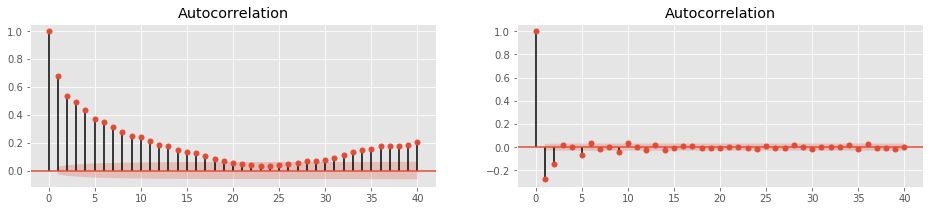

In [94]:
# one differencing acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_acf(detrended.Actual, lags=40, ax=axes[0])
plot_acf(detrended.Actual.diff().dropna(),lags=40, ax=axes[ 1])

plt.show()

In [123]:
# arima (2,1,1)
from statsmodels.tsa.arima_model import ARIMA

model_1 = ARIMA(detrended.Actual, order=(2,0,1))
model_fit_1 = model_1.fit(disp=0)
print(model_fit_1.summary())

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 5044
Model:                     ARMA(2, 1)   Log Likelihood              -18530.511
Method:                       css-mle   S.D. of innovations              9.533
Date:                Sat, 08 Aug 2020   AIC                          37071.022
Time:                        20:09:51   BIC                          37103.652
Sample:                    12-23-2019   HQIC                         37082.453
                         - 04-06-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           36.1216      0.683     52.913      0.000      34.784      37.460
ar.L1.Actual     1.2100      0.041     29.790      0.000       1.130       1.290
ar.L2.Actual    -0.2753      0.032     -8.50

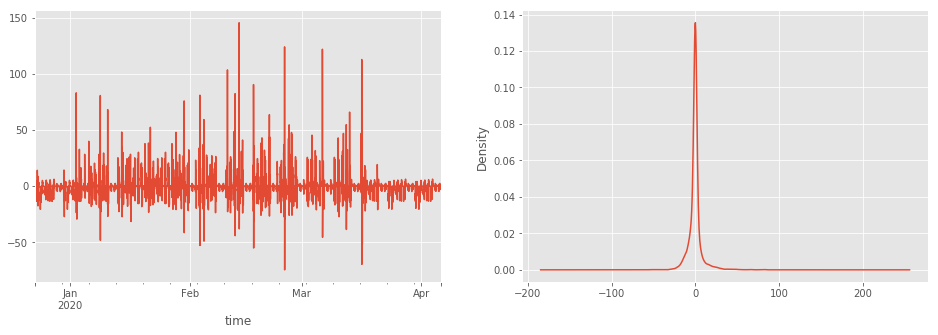

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit_1.resid.plot(ax=axes[0])
model_fit_1.resid.plot(kind='kde', ax=axes[1])

Text(0, 0.5, 'Wh')

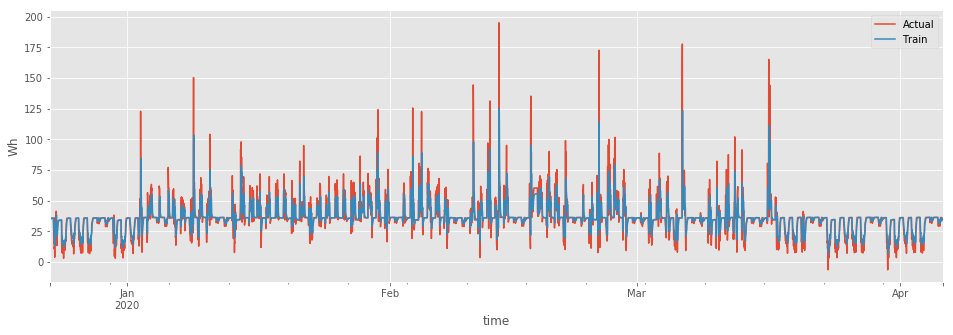

In [118]:
# predict the model
predict= model_fit_1.predict(dynamic=False)
df_predict= pd.DataFrame(predict, columns=({'Train'}))
df_sub_pred = detrended.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_sub_pred.set_index(df_sub_pred.index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [26]:
next_halfhour=model_fit_1.forecast(steps=1, exog=None, alpha=0.05)
print(next_halfhour)
print('Actual: ',df_half['Actual'][6451:6452])

NameError: name 'model_fit_1' is not defined

In [120]:
mae = np.mean(np.abs(df_sub_pred['Train'] - df_sub_pred['Actual']))
rmse = np.mean((df_sub_pred['Train'] - df_sub_pred['Actual'])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  4.190634408865521 RMSE:  9.533018692076348


In [126]:
# turn next hour prediction to real prediction
real_next_pred = next_halfhour[0]+ decom.seasonal[0]
print ('Real Prediction: ' ,real_next_pred, 'Actual Next Hour: ', df_half['Actual'][5044:5045].values )

Real Prediction:  [28.04690895] Actual Next Hour:  [28.]


In [124]:
# add decom.season
df_sub_pred['Train'] = df_sub_pred['Train']+decom.seasonal
df_sub_pred['Actual'] = df_sub_pred['Actual']+decom.seasonal

Text(0, 0.5, 'Wh')

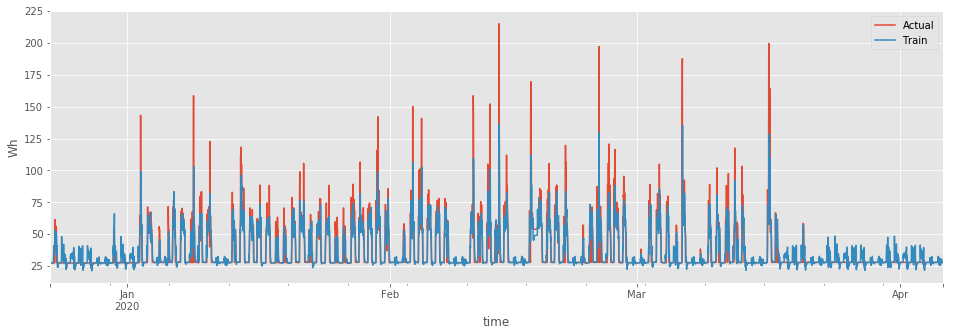

In [125]:
# plot the result
df_sub_pred.set_index(df_sub_pred.index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [28]:
df_sub['Actual'].mean()

34.34740640473285

In [ ]:
# with lockdown
mad_mean_ratio =8.17*6451/(df_all['Actual'][:6451]).sum() 
mad_mean_ratio